In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
os.environ["WANDB_API_KEY"] = "0" ## 0 to silence warning of Weights & Biases

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf

2022-03-15 13:29:22.871356: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-03-15 13:29:22.871474: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# **Downloading Data**

*The training set contains a premise, a hypothesis, a label (0 = entailment, 1 = neutral, 2 = contradiction), and the language of the text. For more information about what these mean and how the data is structured, check out the data page: https://www.kaggle.com/c/contradictory-my-dear-watson/data*

In [4]:
#FC to download the data outside of kaggle
#!kaggle competitions download -c contradictory-my-dear-watson 

In [5]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

In [6]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [7]:
#FC : only French texts
train[train.lang_abv=='fr'].head()

,id,premise,hypothesis,lang_abv,language,label
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
41,b277ab420e,regarder une fille dans un parka en fourrure b...,La fille est habillée tout en rouge.,fr,French,2
60,bda3f7467b,"Correctement mise en œuvre, cette approche fou...",L'approche vous montre le voyage qui a eu lieu.,fr,French,0
69,26ef4fcb0c,La complexité du subjonctif en français ne le ...,Il n'essaie pas parce qu'il n'a aucune motivat...,fr,French,1
70,7fa1543ed0,La Maison Blanche va-t-elle se raviser ?,La Maison-Blanche changera-t-elle d'avis ?,fr,French,0


In [8]:
print("Entailment example","\n")
print(train.premise.values[2])
print(train.hypothesis.values[2])
print(train.label.values[2])

Entailment example 

Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
J'essayais d'accomplir quelque chose.
0


In [9]:
print("Neutral example","\n")
print(train.premise.values[69])
print(train.hypothesis.values[69])
print(train.label.values[69])

Neutral example 

La complexité du subjonctif en français ne le soucie pas le moins du monde, pour la bonne et simple raison qu'il n'essaye pas de l'employer.
Il n'essaie pas parce qu'il n'a aucune motivation.
1


In [10]:
print("Contradictory example","\n")
print(train.premise.values[41])
print(train.hypothesis.values[41])
print(train.label.values[41])

Contradictory example 

regarder une fille dans un parka en fourrure blanche avec des bottes
La fille est habillée tout en rouge.
2


Let's look at the size of the dataset and the distribution of languages in the training set.

Dataset from https://www.kaggle.com/hugoarmandopazvivas/contradictory-my-dear-watson-hapv

In [11]:
#!pip3 install datasets version==1
#!pip3 install sentencepiece

In [12]:
#We are going to import more data to train our model

****

In [13]:
!pip install nlp
from nlp import load_dataset

     |████████████████████████████████| 1.7 MB 1.8 MB/s 


In [14]:
def load_mnli(use_validation=True):
    result = []
    dataset = load_dataset('multi_nli')
    print(dataset['train'])
    keys = ['train', 'validation_matched','validation_mismatched'] if use_validation else ['train']
    for k in keys:
        for record in dataset[k]:
            c1, c2, c3 = record['premise'], record['hypothesis'], record['label']
            if c1 and c2 and c3 in {0,1,2}:
                result.append((c1,c2,c3,'en'))
    result = pd.DataFrame(result, columns=['premise','hypothesis', 'label','lang_abv'])
    return result

In [15]:
mnli = load_mnli()

Downloading:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/227M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/plain_text/1.0.0/60774175381b9f3f1e6ae1028229e3cdb270d50379f45b9f2c01008f50f09e6b. Subsequent calls will reuse this data.
Dataset(features: {'premise': Value(dtype='string', id=None), 'hypothesis': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=3, names=['entailment', 'neutral', 'contradiction'], names_file=None, id=None)}, num_rows: 392702)


In [16]:
total_train = train[['id', 'premise', 'hypothesis','lang_abv', 'language', 'label']]
total_train

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [17]:
mnli = mnli[['premise', 'hypothesis', 'lang_abv', 'label']]
mnli.insert(0, 'language', 'English')
mnli = mnli[['premise', 'hypothesis', 'lang_abv', 'language', 'label']]
mnli.insert(0, 'id', 'xxx')
mnli

,id,premise,hypothesis,lang_abv,language,label
0,xxx,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,en,English,1
1,xxx,you know during the season and i guess at at y...,You lose the things to the following level if ...,en,English,0
2,xxx,One of our number will carry out your instruct...,A member of my team will execute your orders w...,en,English,0
3,xxx,How do you know? All this is their information...,This information belongs to them.,en,English,0
4,xxx,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,en,English,1
...,...,...,...,...,...,...
412344,xxx,Do you watch that?,Can you see?,en,English,2
412345,xxx,"To a Western ear, the most predictable of lang...","To the Western ear, the least predictable of l...",en,English,2
412346,xxx,The recorder captured the sounds of loud thump...,The recorder didn't capture any of the sounds.,en,English,2
412347,xxx,That's a good attitude!,"You feel good about this, don't you?",en,English,1


In [18]:
total_train = pd.concat([total_train, mnli], axis = 0)
total_train

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
412344,xxx,Do you watch that?,Can you see?,en,English,2
412345,xxx,"To a Western ear, the most predictable of lang...","To the Western ear, the least predictable of l...",en,English,2
412346,xxx,The recorder captured the sounds of loud thump...,The recorder didn't capture any of the sounds.,en,English,2
412347,xxx,That's a good attitude!,"You feel good about this, don't you?",en,English,1


In [19]:
train.describe(include='all')


,id,premise,hypothesis,lang_abv,language,label
count,12120,12120,12120,12120,12120,12120.000000
unique,12120,8209,12119,15,15,NaN
top,5130fd2cb5,and these comments were considered in formulat...,I am not sure.,en,English,NaN
freq,1,3,2,6870,6870,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.990759
std,NaN,NaN,NaN,NaN,NaN,0.824523
min,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,2.000000


In [20]:
test.describe(include='all')

,id,premise,hypothesis,lang_abv,language
count,5195,5195,5195,5195,5195
unique,5195,4336,5195,15,15
top,c6d58c3f69,The movie isn't clear on where the secret repo...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",en,English
freq,1,3,1,2945,2945


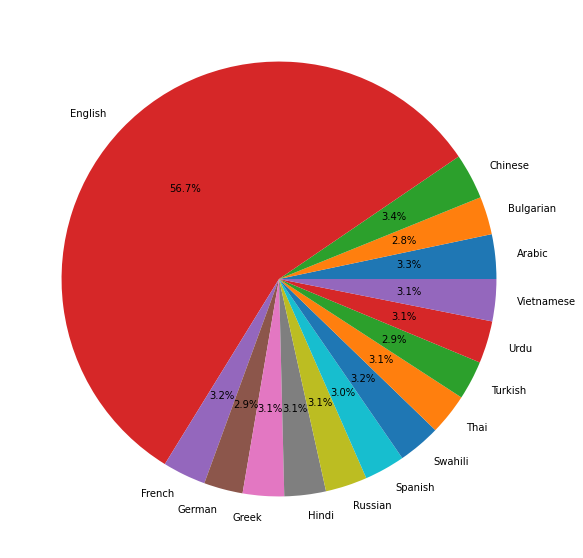

In [21]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


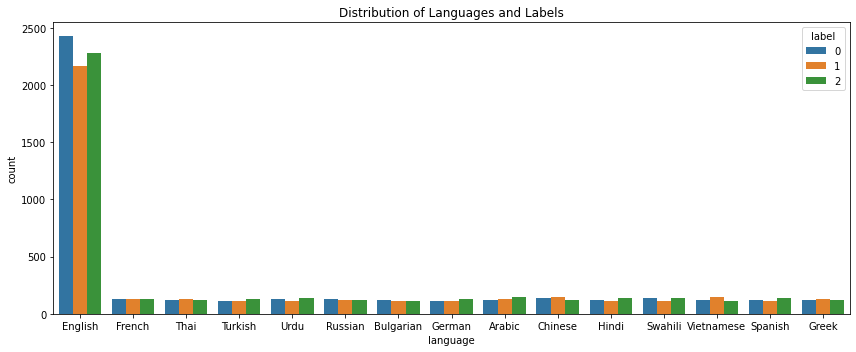

In [22]:
import seaborn as sns
#explore the distribution of classes and languages
fig, ax = plt.subplots(figsize = (12,5))

#for maximum aesthetics
palette = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)

graph1 = sns.countplot(train['language'], hue = train['label'])#, palette = palette)

#set title
graph1.set_title('Distribution of Languages and Labels')

plt.tight_layout()
plt.show()

# **Preparing Data for Input**

In [23]:
from transformers import BertTokenizer, TFBertModel, TFAutoModel,AutoTokenizer

#model_name = "bert-base-multilingual-cased"
#tokenizer = BertTokenizer.from_pretrained(model_name) # FC: this is the tokenizer we will use on our text data to tokenize it

model_name = "joeddav/xlm-roberta-large-xnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

In [24]:
list(tokenizer.tokenize("I love machine learning")) # FC: tokenize only create a list of words

['▁I', '▁love', '▁machine', '▁learning']

In [25]:
# FC we make a function in order to have a list of the id for each word and the separator 
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s)) # FC: split the sentence into tokens that are either words or sub-words
   tokens.append('[SEP]') # FC: a token called [SEP] (=separator) is added to mark end of each sentence
   return tokenizer.convert_tokens_to_ids(tokens) # FC: instead of returning the list of tokens, a list of each token ID is returned

In [26]:
encode_sentence("I love machine learning") # FC: the output is a number for each word plus the ID for the [SEP] token

[87, 5161, 36279, 52080, 3]

In [27]:
def bert_encode(hypotheses, premises, tokenizer): # FC: for RoBERTa we remove the input_type_ids from the inputs of the model
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([   # FC: constructs a constant ragged tensor. every entry has a different length
      encode_sentence(s) for s in np.array(hypotheses)])
  
  sentence2 = tf.ragged.constant([
      encode_sentence(s) for s in np.array(premises)])
  
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0] # FC: list of IDs for the token '[CLS]' to denote each beginning
  
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1) # FC: put everything together. every row still has a different length.
  
  #input_word_ids2 = tf.concat([cls, sentence2, sentence1], axis=-1)
  
  #input_word_ids = tf.concat([input_word_ids1, input_word_ids2], axis=0) # we duplicate the dataset inverting sentence 1 and 2
    
  input_mask = tf.ones_like(input_word_ids).to_tensor() # FC: first, a tensor with just ones in it is constructed in the same size as input_word_ids. Then, by applying to_tensor the ends of each row are padded with zeros to give every row the same length

  # type is not need for the RoBERTa model it will not be include in the output of this function
  type_cls = tf.zeros_like(cls) # FC: creates a tensor same shape as cls with only zeros in it
  
  type_s1 = tf.zeros_like(sentence1)
  
  type_s2 = tf.ones_like(sentence2) # FC: creates a tensor same shape as sentence2 with only ones in it to mark the 2nd sentence
  
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor() # FC: concatenates everything and again adds padding 
  
  inputs = {
      'input_word_ids': input_word_ids.to_tensor(), # FC: input_word_ids hasn't been padded yet - do it here now
      'input_mask': input_mask
      
      #,'input_type_ids': input_type_ids
  }

  return inputs

In [28]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

2022-03-15 13:30:39.029958: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-15 13:30:39.034305: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-03-15 13:30:39.034360: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-15 13:30:39.034403: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (98545693cfd0): /proc/driver/nvidia/version does not exist
2022-03-15 13:30:39.037126: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [29]:
train_input

{'input_word_ids': <tf.Tensor: shape=(12120, 245), dtype=int32, numpy=
 array([[    3,   136,  6097, ...,     0,     0,     0],
        [    3, 32255,   621, ...,     0,     0,     0],
        [    3,  5581, 69332, ...,     0,     0,     0],
        ...,
        [    3,   581,  5526, ...,     0,     0,     0],
        [    3,  1913,    70, ...,     0,     0,     0],
        [    3,  1326, 66570, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(12120, 245), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [30]:
total_train_input = bert_encode(total_train.premise.values, total_train.hypothesis.values, tokenizer)

In [31]:
train.label.values.shape

(12120,)

In [32]:
total_train.label.values.shape

(424469,)

In [33]:
print(np.count_nonzero(train_input['input_word_ids'], axis=1))

[32 37 37 ... 29 28 30]


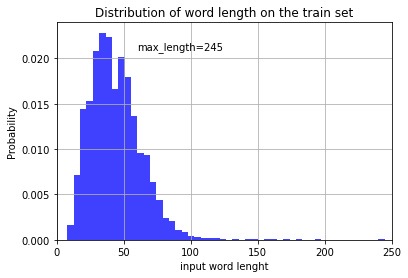

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


x = np.count_nonzero(train_input['input_word_ids'], axis=1)

# the histogram of the data
n, bins, patches = plt.hist(x, 50, density=True, facecolor='b', alpha=0.75)


plt.xlabel('input word lenght')
plt.ylabel('Probability')
plt.title('Distribution of word length on the train set')
plt.text(60, .021, r'max_length=245')
plt.xlim(0, 250)
#plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

In [35]:
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

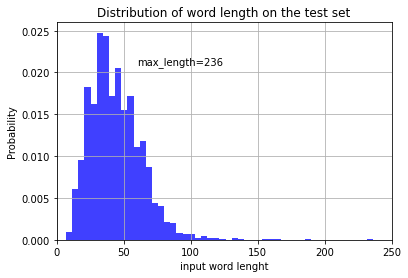

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


x = np.count_nonzero(test_input['input_word_ids'], axis=1)

# the histogram of the data
n, bins, patches = plt.hist(x, 50, density=True, facecolor='b', alpha=0.75)


plt.xlabel('input word lenght')
plt.ylabel('Probability')
plt.title('Distribution of word length on the test set')
plt.text(60, .021, r'max_length=236')
plt.xlim(0, 250)
#plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

# Creating & Training Model

In [37]:
max_len = 236 #: FC 50 in the initial tutorial

def build_model():
    #encoder = TFBertModel.from_pretrained(model_name) 
    # FC: constructs a RoBERTa model pre-trained on the above described language model 'xlm-roberta-large-xnli'
    encoder = TFAutoModel.from_pretrained('joeddav/xlm-roberta-large-xnli')
    # FC: now we adjust the model so that it can accept our input by telling the model what the input looks like:
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids") # FC: tf.keras.Input constructs a symbolic tensor object whith certain attributes: "shape" tells it that the expected input will be in batches of max_len-dimensional vectors; "dtype" tells it that the data type will be int32; "name" will be the name string for the input layer
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask") # FC: repeat the same for the other two input variables
    # FC: the input type is only needed for the BERT model
    #input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    # FC: now follows, what we want to happen with our input:
    # FC: first, our input goes into the BERT model bert_encoder. It will return a tuple and the contextualized embeddings that we need are stored in the first element of that tuple
    embedding = encoder([input_word_ids, input_mask])[0] # FC: add_input_type_ids for the BERT model
    # FC: we only need the output corresponding to the first token [CLS], which is a 2D-tensor with size (#sentence pairs, 768) and is accessd with embedding[:,0,:]. This will be input for our classifier, which is a regular densely-connected neural network constructed through tf.keras.layers.Dense. The inputs mean: "3" is the dimensionality of the output space, which means that the output has shape (#sentence pairs,3). More practically speaking, for each sentence pair that we input, the output will have 3 probability values for each of the 3 possible labels (entailment, neutral, contradiction). They will be in range(0,1) and add up to 1; "activation" denotes the activation function, in this case 'softmax', which connects a real vector to a vector of categorical possibilities.
    
    # I tried to put another layer put it doesn't help in performance
    #output = tf.keras.layers.Dense(10, activation='softmax')(embedding[:,0,:]) #FC: no need of a GlobalAveragePooling for BERT
    
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    # FC: we also have the posibility of making a globalAveragepooling of all the embeddings, but the resuls are not better 
    #output = tf.keras.layers.GlobalAveragePooling1D()(embedding) 
    #output = tf.keras.layers.Dense(3, activation='softmax')(output) 
    
       
    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output) # FC: based on the code in the lines above, a model is now constructed and passed into the variable model
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy']) # FC: we tell the model how we want it to train and evaluate: "tf.keras.optimizers.Adam": use an optimizer that implements the Adam algorithm. "lr" denotes the learning rate; "loss" denotes the loss function to use; "metrics" specifies which kind of metrics to use for training and testing
    
    return model 

In [38]:
try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # FC: detect and init the TPU: TPUClusterResolver() locates the TPUs on the network
    # instantiate a distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # FC: "strategy" contains the necessary distributed training code that will work on the TPUs
except ValueError: # FC: in case Accelerator is not set to TPU in the Notebook Settings
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync) # FC: returns the number of cores

2022-03-15 13:35:15.376246: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-03-15 13:35:15.376381: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-03-15 13:35:15.396364: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-03-15 13:35:15.396422: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-03-15 13:35:15.397174: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30020


In [39]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu,) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.0.0.2:8470']
Number of accelerators:  8


Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

2022-03-15 13:36:46.926547: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.
2022-03-15 13:36:49.438266: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.
2022-03-15 13:36:52.034533: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.
2022-03-15 13:36:54.647750: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.
2022-03-15 13:36:57.208880: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.
Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. i

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 236)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 236)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 1024)         0           tfxlm_roberta_model[0][0]    

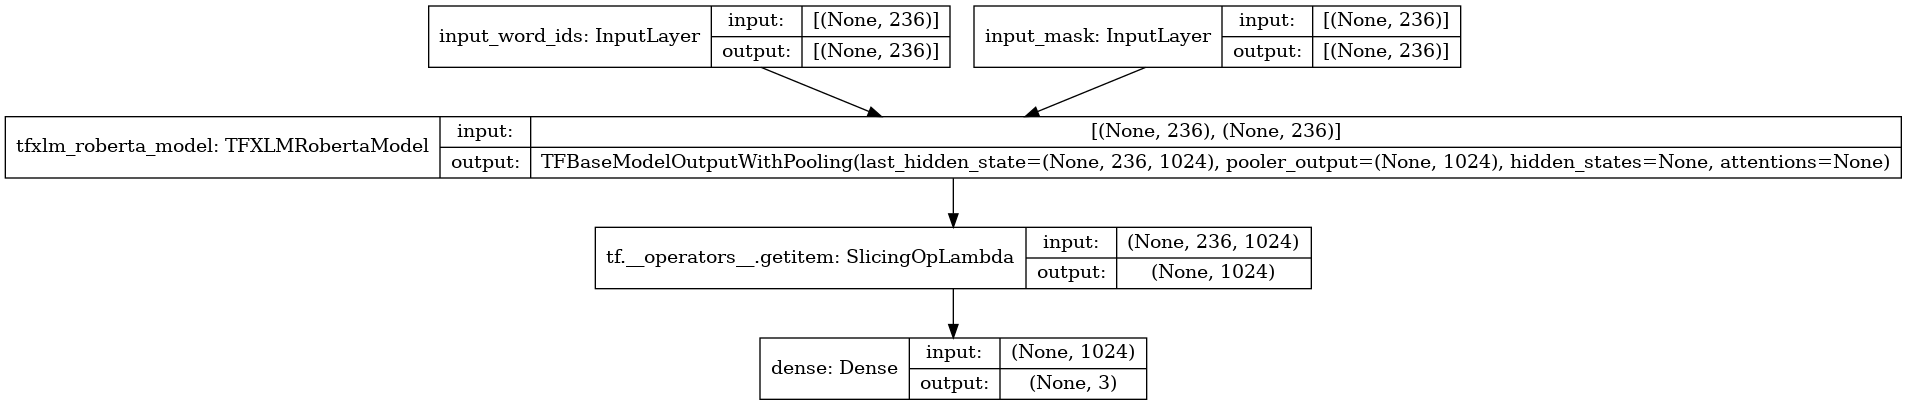

In [40]:
# instantiating the model in the strategy scope creates the model on the TPU

with strategy.scope(): # FC: defines the compute distribution policy for building the model. or in other words: makes sure that the model is created on the TPU/GPU/CPU, depending on to what the Accelerator is set in the Notebook Settings
    model = build_model() # FC: our model is being built
    model.summary()       # FC: let's look at some of its properties

tf.keras.utils.plot_model(model, "my_model.png", show_shapes=True) # FC: I added this line because it gives a nice visualization showing the individual components of our model

In [41]:
# We can freeze the RoBERTa weights in order to save some time
print(model.layers[2])
model.layers[2].trainable=True

In [42]:
# We need to put the train set with the same size of the model
for key in train_input.keys():
    train_input[key] = train_input[key][:,:max_len]

In [43]:
# We need to put the train set with the same size of the model
for key in total_train_input.keys():
    total_train_input[key] = total_train_input[key][:,:max_len]

In [44]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# FC: make sure that TPU in Accelerator under Notebook Settings is turned on so that model trains on the TPU. Otherwise this line will crash
model.fit(total_train_input, total_train.label.values, epochs = 30, verbose = 1, validation_split = 0.01,
         batch_size=16*strategy.num_replicas_in_sync
          ,callbacks=[early_stop]
         ) # FC: now we fit the model to our training data that we prepared before. The number of training epochs is 2, verbose = 1 shows progress bar, # of rows in each batch is 64, and 20% of the data is used for validation

Epoch 1/30


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


3283/3283 [==============================] - 1425s 400ms/step - loss: 0.2511 - accuracy: 0.9106 - val_loss: 0.3355 - val_accuracy: 0.8876
Epoch 2/30
3283/3283 [==============================] - 1283s 391ms/step - loss: 0.1779 - accuracy: 0.9381 - val_loss: 0.3669 - val_accuracy: 0.8881
Epoch 3/30
3283/3283 [==============================] - 1283s 391ms/step - loss: 0.1370 - accuracy: 0.9533 - val_loss: 0.3736 - val_accuracy: 0.8879
Epoch 4/30
3283/3283 [==============================] - 1284s 391ms/step - loss: 0.1073 - accuracy: 0.9634 - val_loss: 0.4416 - val_accuracy: 0.8876


In [45]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer) # FC: finally we prepare our competition data for the model

In [46]:
# same for the test set we need to put it in the same size of the model
for key in test_input.keys():
    test_input[key] = test_input[key][:,:max_len]

In [47]:
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


# Generating & Submitting Predictions

In [48]:
predictions = [np.argmax(i) for i in model.predict(test_input)] # FC; ve the model predict three categorical probabilities, choose the highest probability, and save the respective label ID (0,1, or 2)

In [49]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

In [50]:
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1


In [51]:
submission.to_csv("submission.csv", index = False)